In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from datasets import load_dataset
from tqdm import tqdm
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
import scienceplots
import matplotlib.pyplot as plt
plt.style.use(['science', 'no-latex'])

# IMDB

In [28]:
# Configurations
MODEL_NAME = "fabriceyhc/bert-base-uncased-imdb"  # Change as needed
BATCH_SIZE = 32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Load Model & Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, cache_dir = '/Data')
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, output_attentions=True, cache_dir = '/Data').to(DEVICE)

tokenizer_config.json:   0%|          | 0.00/321 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [31]:
dataset = load_dataset("imdb", cache_dir='/Data', split = 'train')\
    .train_test_split(test_size=2000, train_size=10000, seed = 1)

train_texts, train_labels = dataset["train"]["text"], dataset["train"]["label"]  # Sample subset
test_texts, test_labels = dataset["test"]["text"], dataset["test"]["label"]  # Sample subset

# Tokenization
train_encodings = tokenizer(train_texts, truncation=True, padding='max_length', max_length=256, return_tensors="pt")
test_encodings = tokenizer(test_texts, truncation=True, padding='max_length', max_length=256, return_tensors="pt")

In [32]:

# Sample Dataset (Binary Sentiment Classification)


# Create Torch Dataset
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}, torch.tensor(self.labels[idx])

train_dataset = TextDataset(train_encodings, train_labels)
test_dataset = TextDataset(test_encodings, test_labels)

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [33]:
def extract_attention_features(model, dataloader):
    """Extracts attention features where each token's attention score is with respect to [CLS]."""
    model.eval()
    attention_data = {layer: [] for layer in range(model.config.num_hidden_layers)}
    labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            inputs, batch_labels = batch
            inputs = {key: val.to(DEVICE) for key, val in inputs.items()}
            labels.extend(batch_labels.numpy())

            outputs = model(**inputs)
            attentions = outputs.attentions  # Shape: (num_layers, batch_size, num_heads, seq_len, seq_len)

            for layer_idx, layer_attention in enumerate(attentions):
                batch_size, num_heads, seq_len, _ = layer_attention.shape
                cls_attention = layer_attention[:, :, 0, :]  # Extract attention from [CLS] to all tokens
                cls_attention = cls_attention.cpu().numpy().reshape(batch_size, num_heads, -1)  # Flatten seq_len
                attention_data[layer_idx].extend(cls_attention)  # Collect attention per head

    return attention_data, np.array(labels)

In [34]:
# Extract features
train_features, train_labels = extract_attention_features(model, train_loader)
test_features, test_labels = extract_attention_features(model, test_loader)

100%|██████████| 63/63 [00:08<00:00,  7.04it/s]


In [40]:
results = []
NUM_PCA_COMPONENTS = 10

for layer in range(model.config.num_hidden_layers):
    train_X = np.array(train_features[layer])  # Shape: (num_samples, num_heads, seq_len)
    test_X = np.array(test_features[layer])

    num_heads = train_X.shape[1]
    for head in range(num_heads):
        # Apply PCA
        pca = PCA(n_components=NUM_PCA_COMPONENTS)
        train_X_reduced = pca.fit_transform(train_X[:, head, :])  # Reduce dimension
        test_X_reduced = pca.transform(test_X[:, head, :])

        # Train Logistic Regression
        clf = LogisticRegression(max_iter=200)
        clf.fit(train_X_reduced, train_labels)
        
        # Evaluate
        predictions = clf.predict(test_X_reduced)
        acc = accuracy_score(test_labels, predictions)

        results.append({
            'layer':layer, 
            'head':head, 
            'acc':acc
        })


In [41]:
probing_matrix = pd.DataFrame(results)\
    .pivot(index = 'layer', columns='head')


In [42]:
probing_matrix_sorted = pd.DataFrame(np.sort(probing_matrix.values, axis=1, )[:, ::-1], index=probing_matrix.index, columns=probing_matrix.columns)\
    .droplevel(0, axis = 1)

In [43]:
probing_matrix_sorted.sum(axis = 1)

layer
0     6.3165
1     6.8155
2     7.9255
3     7.0710
4     6.2050
5     6.1050
6     6.2175
7     6.0600
8     6.4150
9     6.9270
10    7.0585
11    6.5820
dtype: float64

Text(0.5, 1.0, 'Linear probing: IMDB dataset')

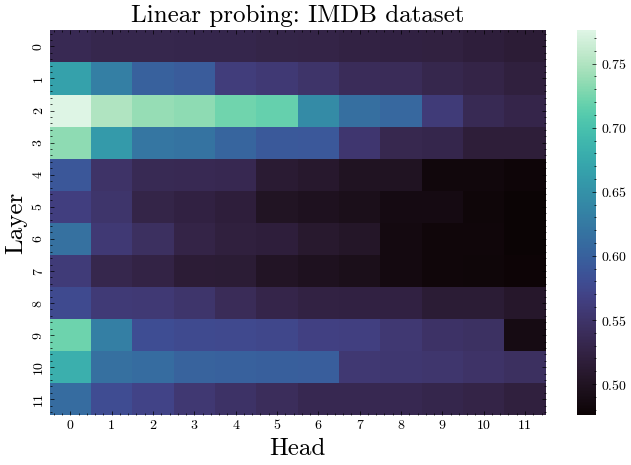

In [44]:
plt.figure(figsize=(8,5))
sns.heatmap(probing_matrix_sorted, cmap='mako')
plt.xlabel("Head", fontsize = 18)
plt.ylabel("Layer", fontsize = 18)
plt.title("Linear probing: IMDB dataset", fontsize = 18)

# SST2

In [2]:
# Configurations
MODEL_NAME = "Bhumika/roberta-base-finetuned-sst2"  # Change as needed
BATCH_SIZE = 32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Load Model & Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, cache_dir = '/Data')
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, output_attentions=True, cache_dir = '/Data').to(DEVICE)

tokenizer_config.json:   0%|          | 0.00/439 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/847 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [49]:
dataset = load_dataset("stanfordnlp/sst2", cache_dir='/Data', split = 'train')\
    .train_test_split(test_size=2000, train_size=10000, seed = 1)

train_texts, train_labels = dataset["train"]["sentence"], dataset["train"]["label"]  # Sample subset
test_texts, test_labels = dataset["test"]["sentence"], dataset["test"]["label"]  # Sample subset

# Tokenization
train_encodings = tokenizer(train_texts, truncation=True, padding='max_length', max_length=512, return_tensors="pt")
test_encodings = tokenizer(test_texts, truncation=True, padding='max_length', max_length=512, return_tensors="pt")

In [50]:



# Create Torch Dataset
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}, torch.tensor(self.labels[idx])

train_dataset = TextDataset(train_encodings, train_labels)
test_dataset = TextDataset(test_encodings, test_labels)

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [51]:
def extract_attention_features(model, dataloader):
    """Extracts attention features where each token's attention score is with respect to [CLS]."""
    model.eval()
    attention_data = {layer: [] for layer in range(model.config.num_hidden_layers)}
    labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            inputs, batch_labels = batch
            inputs = {key: val.to(DEVICE) for key, val in inputs.items()}
            labels.extend(batch_labels.numpy())

            outputs = model(**inputs)
            attentions = outputs.attentions  # Shape: (num_layers, batch_size, num_heads, seq_len, seq_len)

            for layer_idx, layer_attention in enumerate(attentions):
                batch_size, num_heads, seq_len, _ = layer_attention.shape
                cls_attention = layer_attention[:, :, 0, :]  # Extract attention from [CLS] to all tokens
                cls_attention = cls_attention.cpu().numpy().reshape(batch_size, num_heads, -1)  # Flatten seq_len
                attention_data[layer_idx].extend(cls_attention)  # Collect attention per head

    return attention_data, np.array(labels)

In [52]:
# Extract features
train_features, train_labels = extract_attention_features(model, train_loader)
test_features, test_labels = extract_attention_features(model, test_loader)

100%|██████████| 63/63 [00:20<00:00,  3.13it/s]


In [58]:
results = []
NUM_PCA_COMPONENTS = 10

for layer in range(model.config.num_hidden_layers):
    train_X = np.array(train_features[layer])  # Shape: (num_samples, num_heads, seq_len)
    test_X = np.array(test_features[layer])

    num_heads = train_X.shape[1]
    for head in range(num_heads):
        # Apply PCA
        pca = PCA(n_components=NUM_PCA_COMPONENTS)
        train_X_reduced = pca.fit_transform(train_X[:, head, :])  # Reduce dimension
        test_X_reduced = pca.transform(test_X[:, head, :])

        # Train Logistic Regression
        clf = LogisticRegression(max_iter=200)
        clf.fit(train_X_reduced, train_labels)
        
        # Evaluate
        predictions = clf.predict(test_X_reduced)
        acc = accuracy_score(test_labels, predictions)

        results.append({
            'layer':layer, 
            'head':head, 
            'acc':acc
        })


In [59]:
probing_matrix = pd.DataFrame(results)\
    .pivot(index = 'layer', columns='head')


In [60]:
probing_matrix_sorted = pd.DataFrame(np.sort(probing_matrix.values, axis=1, )[:, ::-1], index=probing_matrix.index, columns=probing_matrix.columns)\
    .droplevel(0, axis = 1)

In [61]:
probing_matrix_sorted.sum(axis = 1)

layer
0     6.7105
1     6.8400
2     6.8765
3     6.8620
4     6.7990
5     6.8630
6     6.9055
7     6.8365
8     6.9460
9     7.0345
10    6.8000
11    7.0235
dtype: float64

Text(0.5, 1.0, 'Linear probing: SST2 dataset')

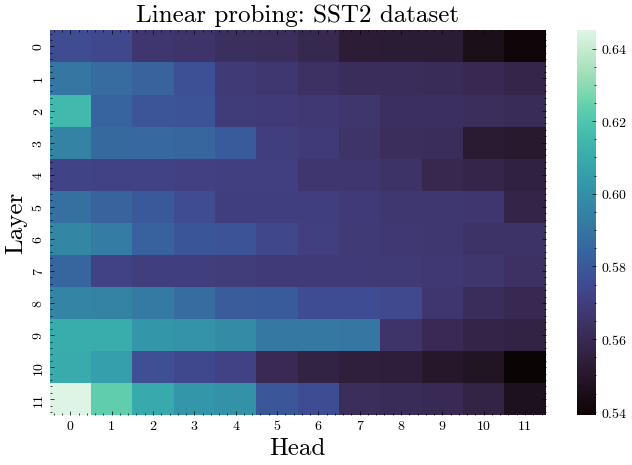

In [62]:
plt.figure(figsize=(8,5))
sns.heatmap(probing_matrix_sorted, cmap='mako')
plt.xlabel("Head", fontsize = 18)
plt.ylabel("Layer", fontsize = 18)
plt.title("Linear probing: SST2 dataset", fontsize = 18)